In [45]:
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
img_size=256
Batch_size=32
channels=3
Epochs=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=Batch_size
)

Found 2152 files belonging to 3 classes.


In [48]:
class_names =dataset.class_names
class_names

['Early_blight', 'Healthy', 'Late_blight']

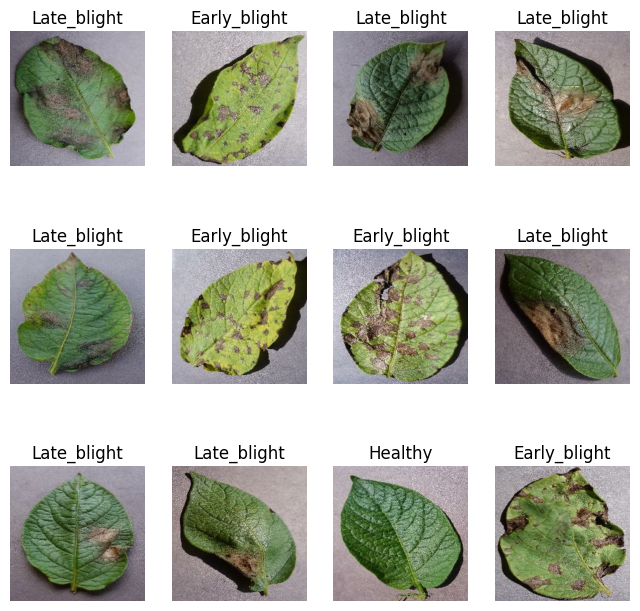

In [7]:
for image_batch,label_batch in dataset.take(1):
    plt.figure(figsize=(8,8))
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [8]:
def get_dataset_partitions(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(dataset)

    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    test_size=int(test_split*ds_size)
    
    train_ds=dataset.take(train_size)
    temp_test=dataset.skip(train_size)
    val_ds=temp_test.take(test_size)
    test_ds=temp_test.skip(test_size)

    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds = get_dataset_partitions(dataset)

In [10]:
len(train_ds)

54

In [11]:
len(test_ds)

8

In [12]:
len(val_ds)

6

In [13]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(img_size,img_size),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [16]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation="relu", input_shape=(img_size,img_size)),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(len(class_names),activation="softmax")
])
model.build(input_shape=(Batch_size,img_size,img_size,channels))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [18]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [19]:
history = model.fit(train_ds,
          epochs=Epochs,
          batch_size=Batch_size,
          verbose=1,
          validation_data=val_ds
          )

Epoch 1/50
54/54 [==============================] - 22s 199ms/step - loss: 0.9113 - accuracy: 0.4867 - val_loss: 0.8141 - val_accuracy: 0.5729
Epoch 2/50
54/54 [==============================] - 10s 184ms/step - loss: 0.6979 - accuracy: 0.6609 - val_loss: 0.5141 - val_accuracy: 0.7604
Epoch 3/50
54/54 [==============================] - 11s 200ms/step - loss: 0.5098 - accuracy: 0.7818 - val_loss: 0.9943 - val_accuracy: 0.4792
Epoch 4/50
54/54 [==============================] - 11s 204ms/step - loss: 0.5834 - accuracy: 0.7558 - val_loss: 0.4066 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 10s 186ms/step - loss: 0.3662 - accuracy: 0.8513 - val_loss: 0.5058 - val_accuracy: 0.7292
Epoch 6/50
54/54 [==============================] - 10s 184ms/step - loss: 0.2965 - accuracy: 0.8906 - val_loss: 0.2712 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 10s 177ms/step - loss: 0.2345 - accuracy: 0.9068 - val_loss: 0.1376 - val_accuracy: 0.9479

In [20]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 35ms/step - loss: 0.0222 - accuracy: 0.9883


In [22]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
accuraacy = history.history["accuracy"]
val_acc =  history.history["val_accuracy"]
loss =  history.history["loss"]
val_loss =  history.history["val_loss"]

Text(0.5, 1.0, 'Traning and Validation Accuracy')

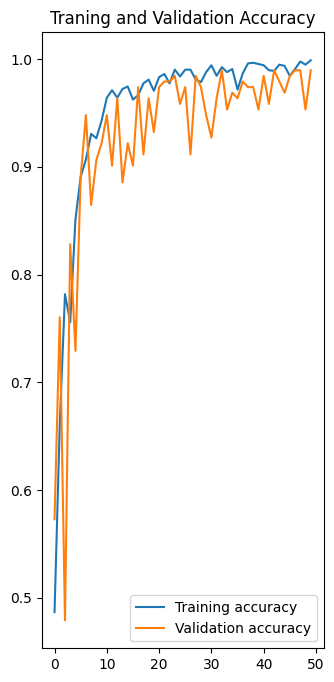

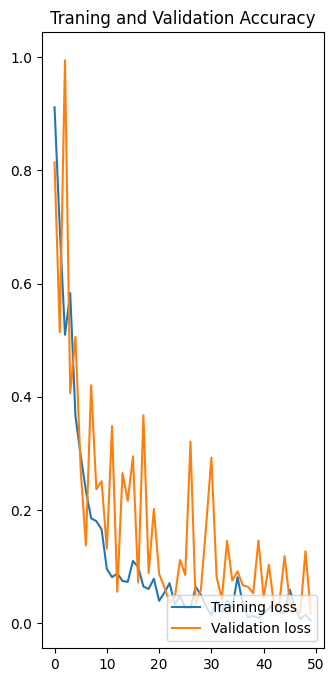

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs),accuraacy,label="Training accuracy")
plt.plot(range(Epochs),val_acc,label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Traning and Validation Accuracy")

plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(Epochs),loss,label="Training loss")
plt.plot(range(Epochs),val_loss,label="Validation loss")
plt.legend(loc="lower right")
plt.title("Traning and Validation Accuracy")

1/1 [==============================] - 0s 45ms/step


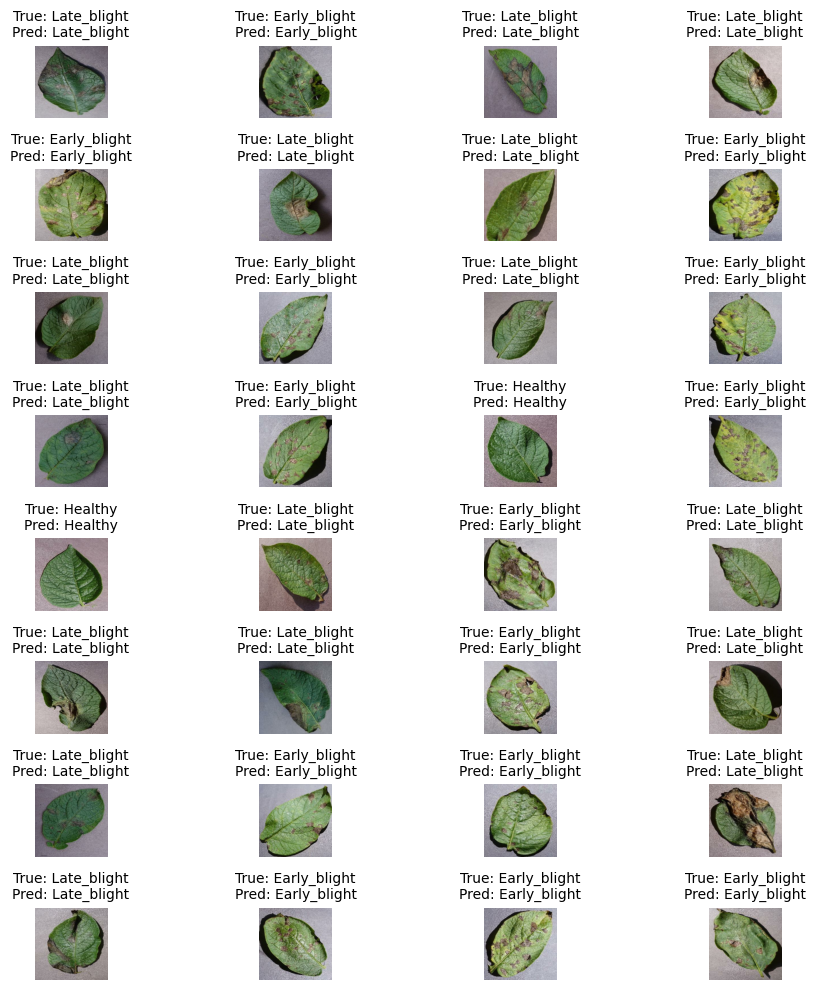

In [73]:
def plot_images(images, labels_true, labels_pred, class_names, nrows=4, ncols=8):
    fig = plt.figure(figsize=(10,10))
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        true_label = class_names[labels_true[i].numpy()]
        pred_label = class_names[labels_pred[i]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.tight_layout()
    plt.show()

for images_batch, label_batch in test_ds.take(1):
    batch_predictions = model.predict(images_batch)
    predicted_labels = np.argmax(batch_predictions, axis=1)
    plot_images(images_batch, label_batch, predicted_labels, class_names, nrows=8, ncols=4)
